In [244]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from scipy import stats

In [245]:
import h5py

In [246]:
def suffix_number(fname):
    filename, file_extension = os.path.splitext(os.path.basename(fname))
    number = int(filename.split("_")[1])
    return number

In [247]:
dir = "diags"
diags_dir = "noisy_no_subcycling_1e+17_100_100"
B_0 = 0.02
n_0 = 1e17
E_0 = 20_000
files = list(
    sorted(
        map(lambda x: os.path.join(dir, diags_dir, x), filter(lambda x: x.startswith("openpmd"), os.listdir(os.path.join(dir, diags_dir)))),
        key = suffix_number
    )
)

In [248]:
def load_fields(filename):
    file = h5py.File(filename, 'r')
    key = list(file['data'].keys())[0]

    dset = file['data'][key]
    t = dset.attrs['time']
    
    fields = dset['fields']
    Ez = fields['E']['z']
    rho_ions = fields['rho_ions']
    rho_electrons = fields['rho_electrons']

    dx = fields['rho_ions'].attrs['gridSpacing'][0]

    results = {
        "t": t,
        "dx": dx,
        "rho_ions": rho_ions[:],
        "rho_electrons": rho_electrons[:],
        "Ez": Ez[:]
    }

    file.close()

    return results

In [249]:
def load_all_fields(files):
    data = [load_fields(file) for file in files]

    ts = [dat["t"] for dat in data]
    Nt = len(ts)
    Nx = len(data[0]["Ez"])

    dx = data[0]["dx"]

    xs = np.arange(Nx) * dx + dx/2

    q_e = 1.60217663e-19

    n_i = np.array([dat["rho_ions"] / q_e for dat in data])
    n_e = np.array([- dat["rho_electrons"] / q_e for dat in data])
    Ez = np.array([dat["Ez"] for dat in data])

    data = {
        "t": ts,
        "x": xs,
        "E_z": Ez,
        "n_i": n_i,
        "n_e": n_e
    }

    return data

In [250]:
data = load_all_fields(files[1:])

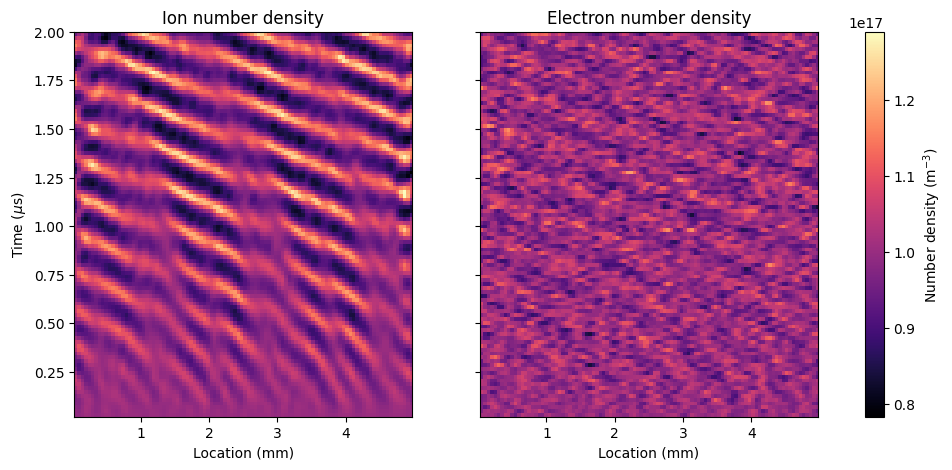

In [251]:
xmin_mm = data["x"][0] * 1000
xmax_mm = data["x"][-1] * 1000

use_window = False

if (use_window):
    windowsize_s = 1e-6
    start_time_s = 1e-6
    dt = data["t"][1] - data["t"][0]

    N_window = round(windowsize_s / dt / 2)
    start_ind = round(start_time_s / dt)

    t_inds = range(start_ind - N_window ,start_ind + N_window)

else:
    t_inds = range(0, len(data["t"]))

tmin_us = np.array(data["t"])[t_inds][0 ] * 1e6
tmax_us = np.array(data["t"])[t_inds][-1] * 1e6

extent = (xmin_mm, xmax_mm, tmin_us, tmax_us)

flipaxis = 1
ni = np.flip(data["n_i"][t_inds], axis = flipaxis)
ne = np.flip(data["n_e"][t_inds], axis = flipaxis)
E = np.flip(data["E_z"][t_inds], axis = flipaxis)

fig, (ax_ions, ax_electrons) = plt.subplots(1, 2, figsize = (12, 5), sharey = True)
cmap = 'magma'
img_i = ax_ions.imshow(ni, origin = 'lower', aspect = 'auto', extent = extent, cmap = cmap, interpolation = 'none')
img_e = ax_electrons.imshow(ne, origin = 'lower', aspect = 'auto', extent = extent, cmap = cmap, interpolation = 'none')

images = [img_i, img_e]

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

cbar = fig.colorbar(images[0], ax = [ax_ions, ax_electrons])

cbar.ax.set_ylabel(r"Number density (m$^{-3}$)")

for species, ax in zip(["Ion", "Electron"], [ax_ions, ax_electrons]):
    ax.set_xlim(xmin_mm, xmax_mm)
    ax.set_xlabel("Location (mm)")
    ax.set_title(species + " number density");

ax_ions.set_ylabel(r"Time ($\mu$s)");

plt.savefig(os.path.join(dir, diags_dir, "fields.png"), dpi = 150)

In [252]:
def load_particles(filename):
    file = h5py.File(filename, 'r')
    key = list(file['data'].keys())[0]

    dset = file['data'][key]
    t = dset.attrs['time']
    
    electrons = dset['particles/electrons']
    ions = dset['particles/ions']

    results = {
        "t": t,
        "w": electrons["weighting"][0],
        "ions": {
            "m": ions["mass"].attrs["value"],
            "x": ions["xPos"][:],
            "z": ions["position"]["z"][:],
            "ux": ions["momentum"]["x"][:],
            "uy": ions["momentum"]["y"][:],
            "uz": ions["momentum"]["z"][:],
        },
        "electrons": {
            "m": electrons["mass"].attrs["value"],
            "x": electrons["xPos"][:],
            "z": electrons["position"]["z"][:],
            "ux": electrons["momentum"]["x"][:],
            "uy": electrons["momentum"]["y"][:],
            "uz": electrons["momentum"]["z"][:],
        }
    }
    file.close()

    return results

1000000.0 999264.3590803851


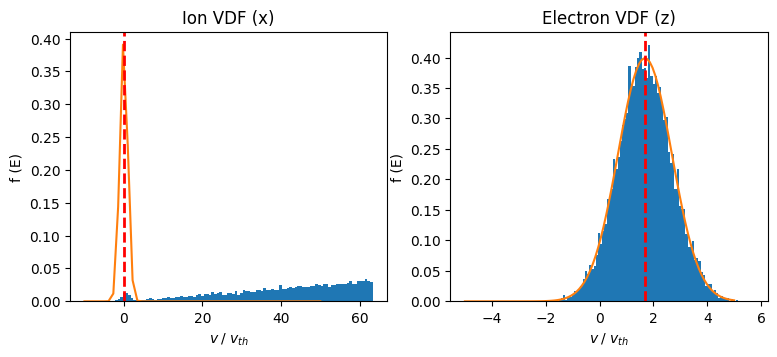

In [253]:
results = load_particles(files[1])

v_ExB = E_0 / B_0

ions = results["ions"]
m_i = ions["m"]

electrons = results["electrons"]
m_e = electrons["m"]
q_e = 1.6e-19

Emax_i = 2
Emax_e = 80

q_e = 1.6e-19
T_i = 0.1
T_e = 2.0

v_i = 0
vi_th = math.sqrt(q_e * T_i / m_i)
ve_th = math.sqrt(q_e * T_e / m_e)

v_es = np.linspace(-5, 5, 100)
f_e = stats.norm.pdf(v_es, loc = v_ExB / ve_th)

v_is = np.linspace(-10, 50)
f_i = stats.norm.pdf(v_is, loc = v_i / vi_th)

bins = 100

fig, (ax_i, ax_e) = plt.subplots(1, 2, figsize = (9, 3.5))
ax_i.hist((ions["ux"] / vi_th / m_i), bins, density = True)
ax_i.plot(v_is, f_i)
ax_i.axvline(v_i/ vi_th, ymin = 0, ymax = 1000, color = "red", ls = "--", lw = 2)
ax_i.set_title("Ion VDF (x)")

ax_e.hist(electrons["uz"] / ve_th / m_e, bins, density = True)
ax_e.plot(v_es, f_e)
ax_e.axvline(v_ExB / ve_th, ymin = 0, ymax = 1000, color = "red", ls = "--", lw = 2)
ax_e.set_title("Electron VDF (z)")

for ax in [ax_e, ax_i]:
    ax.set_xlabel(r"$v \;/\; v_{th}$")
    ax.set_ylabel("f (E)")

print(v_ExB, np.mean(electrons["uz"] / m_e))
plt.savefig(os.path.join(dir, diags_dir, "vdf.png"), dpi = 150)

In [254]:
def temperature(p, m):
    q_e = 1.6e-19
    return m * np.var(p / m) / q_e

In [255]:
def analyze_particle_data(files):
    N = len(files)
    T_e = np.zeros((N, 3))
    T_i = np.zeros((N, 3))
    K = np.zeros(N)
    ux = np.zeros(N)
    uz = np.zeros(N)
    mobility = np.zeros(N)
    t = np.zeros(N)
    w = 0.0

    for (i, f) in enumerate(files):
        print(f)
        particles = load_particles(f)
        electrons = particles["electrons"]
        ions = particles["ions"]
        m_e = electrons["m"]
        m_i = ions["m"]
        w = particles["w"]
        q_e = 1.6e-19

        t[i] = particles["t"]
        
        T_e[i, 0] = temperature(electrons["ux"], m_e)
        T_e[i, 1] = temperature(electrons["uy"], m_e)
        T_e[i, 2] = temperature(electrons["uz"], m_e)

        T_i[i, 0] = temperature(ions["ux"], m_i)
        T_i[i, 1] = temperature(ions["uy"], m_i)
        T_i[i, 2] = temperature(ions["uz"], m_i)
        
        ux[i] = np.mean(electrons["ux"])
        uz[i] = np.mean(electrons["uz"])
        uy = np.mean(electrons["uy"])
        
        K[i] = 0.5 * sum(
            (electrons["ux"] - ux[i])**2 +
            (electrons["uy"] - uy)**2 +
            (electrons["uz"] - uz[i])**2
        ) / q_e / m_e / len(electrons["uz"])

        mobility[i] = np.abs(ux[i] / E_0 / m_e)

    return {
        't': t, 'T_e': T_e, 'T_i': T_i, 'mobility': mobility, "K": K, "ux": ux / m_e, "uz": uz / m_e, "w": w
    }

In [256]:
reducedfiles = [files[ind] for ind in range(1, len(files), 1)]
results = analyze_particle_data(reducedfiles)

diags/noisy_no_subcycling_1e+17_100_100/openpmd_004000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_008000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_012000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_016000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_020000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_024000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_028000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_032000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_036000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_040000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_044000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_048000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_052000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_056000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_060000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_064000.h5
diags/noisy_no_subcycling_1e+17_100_100/openpmd_068000.h5
diags/noisy_no

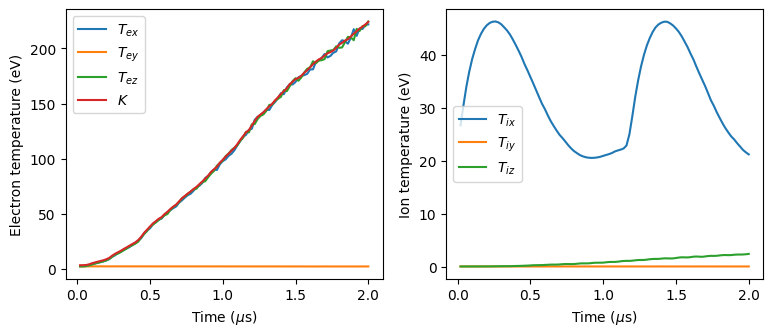

In [257]:
t = results['t']
T_e = results['T_e']
T_i = results['T_i']
mobility = results['mobility']

t_us = t * 1e6

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9, 3.5))
ax1.set_xlabel("Time ($\mu$s)")
ax1.set_ylabel("Electron temperature (eV)")
ax1.plot(t_us, T_e[:, 0], label = "$T_{ex}$")
ax1.plot(t_us, T_e[:, 1], label = "$T_{ey}$")
ax1.plot(t_us, T_e[:, 2], label = "$T_{ez}$")
ax1.plot(t_us, results['K'], label = "$K$")
ax1.legend()

ax2.set_xlabel("Time ($\mu$s)")
ax2.set_ylabel("Ion temperature (eV)")
ax2.plot(t_us, T_i[:, 0], label = r"$T_{ix}$")
ax2.plot(t_us, T_i[:, 1], label = r"$T_{iy}$")
ax2.plot(t_us, T_i[:, 2], label = r"$T_{iz}$")
ax2.legend();

In [258]:
from scipy.integrate import simpson
def mobility_autocorr(x, t, ne, E, windowsize):
    L = x[-1] - x[0]
    int_over_x = np.array([simpson(ne[i, :] * E[i, :], x) / L for i in range(len(t))])
    
    start_ind = windowsize + 1
    last_ind = len(t)

    int_over_t = np.array([
        simpson(int_over_x[i-windowsize:i], t[i-windowsize:i]) / (t[i] - t[i-windowsize]) for i in range(windowsize, last_ind)
    ])

    t_auto = np.array(t[windowsize//2:-windowsize//2])
    mobility = int_over_t / B_0 / n_0 / E_0
    return t_auto, mobility

In [259]:
def running_mean(x):
    return np.cumsum(x) / (np.arange(x.size) + 1)

In [260]:
kernel = np.ones(mobility.size) / mobility.size
mu_running  = running_mean(mobility)

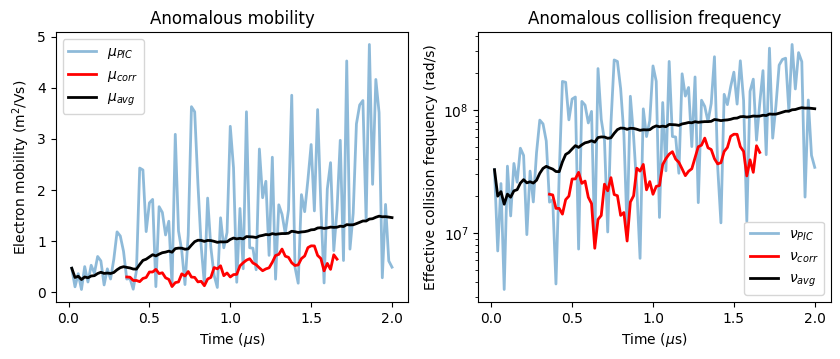

In [261]:
windowsize = round(len(files) / 3)
t_corr, mu_corr = mobility_autocorr(data["x"], data["t"], data["n_e"], data["E_z"], windowsize)

(fig, (ax_mu, ax_nu)) = plt.subplots(1, 2, figsize = (10, 3.5))
ax_mu.set_xlabel("Time ($\mu$s)")
ax_mu.set_ylabel(r"Electron mobility (m$^2$/Vs)")
ax_mu.plot(t_us, mobility, label = r"$\mu_{PIC}$", lw = 2, alpha = 0.5)
ax_mu.plot(t_corr * 1e6, mu_corr, label = r"$\mu_{corr}$", lw = 2, color = "red")
ax_mu.plot(t_us, mu_running, label = r"$\mu_{avg}$", lw = 2, color = "black")
ax_mu.legend()
ax_mu.set_title("Anomalous mobility")

nu_over_mu = q_e / m_e * B_0**2
ax_nu.set_xlabel("Time ($\mu$s)")
ax_nu.set_ylabel("Effective collision frequency (rad/s)")
ax_nu.semilogy(t_us, mobility * nu_over_mu, label = r"$\nu_{PIC}$", lw = 2, alpha = 0.5)
ax_nu.semilogy(t_corr * 1e6, mu_corr * nu_over_mu, label = r"$\nu_{corr}$", lw = 2, color = "red")
ax_nu.semilogy(t_us, mu_running * nu_over_mu, label = r"$\nu_{avg}$", lw = 2, color = "black")
ax_nu.legend()
ax_nu.set_title("Anomalous collision frequency");


In [262]:
[np.mean(mobility), np.mean(mu_corr)]

[1.4574327517563253, 0.4540156021825773]

In [263]:
[np.std(mobility) / np.sqrt(t_us.size), np.std(mu_corr) / np.sqrt(t_corr.size)]

[0.11868100245790363, 0.024341689305452188]

In [264]:
import matplotlib.animation as animation

if (False):
    fig, ax = plt.subplots(1,1)
    results = load_particles(files[1])
    ions = results["ions"]
    m_i = ions["m"]

    s = ax.scatter(ions["z"] / 1e-2, -ions["uz"] / m_i / 1000, s = 2, alpha = 0.05);
    ax.set_xlabel(r"$\theta$ [cm]")
    ax.set_ylabel(r"Ion velocity [km/s]")
    ax.set_xlim(0, 0.5)
    ax.set_ylim(-15, 5)

    def update(frame):
        data = load_particles(files[frame])
        ion_data = data["ions"]
        m_i = ion_data["m"]
        z = ion_data["z"] / 1e-2
        uz = -ion_data["uz"] / m_i / 1000
        s.set_offsets(np.stack([z, uz]).T)
        t_us = data["t"] * 1e6
        ax.set_title(r"t = {:1.2f} $\mu$s".format(t_us))
        return s

    ani = animation.FuncAnimation(fig = fig, func = update, frames = range(1, len(files), 1), interval = 10)
    ani.save("anim_" + diags_dir + ".gif");